# Library

In [266]:
# Installation
%pip install --quiet mesa

Note: you may need to restart the kernel to use updated packages.


In [267]:
# Import
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from tabulate import tabulate

import math
import random

# Class Definition

## Agent

In [268]:
class ChartistAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned, chartist_day_reference):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
        self.n = chartist_day_reference
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2)
        
        # Default Rule : EMA for both opening and closing
        self.is_open_sma_high = False
        self.is_close_sma_high = False
        
        if (np.random.uniform() <= 0.25):
            # Rule : SMA for both opening and closing             
            self.is_open_sma_high = True
            self.is_close_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.5):
            # Rule : SMA for opening and EMA for closing
            self.is_open_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.75):
            # Rule : EMA for opening and SMA for closing
            self.is_close_sma_high = True
    
    def step(self):
        if self.is_close:
            # Potential Buy
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()
            
            # Count Probability to Buy Based on Rule
            probability_to_buy = 0
            if self.model.price < sma_value:
                probability_to_buy += (0.8 if self.is_open_sma_high else 0.2)
            
            if self.model.price > ema_value:
                probability_to_buy += (0.8 if not self.is_open_sma_high else 0.2)
            
            # Actual Buy
            if (np.random.uniform() <= probability_to_buy):
                self.is_close = False
                
                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained

                if (self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent += 1
                elif (self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent += 1
                elif (not self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent += 1
                elif (not self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent += 1
    
        else:
            # Potential Sell
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()

            # Count Probability to Sell Based on Rule
            probability_to_sell = 0
            if self.model.price > sma_value:
                probability_to_sell += (0.8 if self.is_close_sma_high else 0.2)
            
            if self.model.price < ema_value:
                probability_to_sell += (0.8 if not self.is_close_sma_high else 0.2)
            
            # Actual Sell
            if (np.random.uniform() <= probability_to_sell):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += bitcoin_released
                
                if (self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent -= 1
                elif (self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent -= 1
                elif (not self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent -= 1
                elif (not self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent -= 1
        
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2)
                    
    # Agent Helper Function
    # SMA Rule
    def calculate_sma_n_days(self):
        start_index = max(0, len(self.model.price_history) - self.n)
        window = self.model.price_history[start_index:len(self.model.price_history)]

        return sum(window) / len(window)

    # EMA Rule
    def calculate_ema_n_days(self):
        smooth_factor = 2 / (self.n + 1)
        ema = [self.model.price_history[0]]

        for i in range(1, len(self.model.price_history)):
            value = smooth_factor * self.model.price_history[i] + (1 - smooth_factor) * ema[i-1]
            ema.append(value)

        return ema[len(ema)-1]

In [269]:
class RandomAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
    
    def step(self):
        if self.is_close:
            # Actual Buy
            if (random.choice([True, False])):
                self.is_close = False

                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained
                self.model.number_of_open_position_random_agent += 1
    
        else:
            # Actual Sell
            if (random.choice([True, False])):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += bitcoin_released
                self.model.number_of_open_position_random_agent -= 1

        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2)

In [270]:
import random

class BitcoinMarketModel(mesa.Model):
    def __init__(self, price_start, number_of_agents, total_fiat, total_bitcoin, chartist_ratio, chartist_day_reference):
        self.schedule = mesa.time.RandomActivation(self)
        
        self.price = price_start
        self.price_history = [price_start]
        self.number_of_agents = number_of_agents
        
        self.total_fiat = total_fiat
        self.total_bitcoin = total_bitcoin
        self.supply = 0
        self.demand = 0
        
        self.number_of_open_position_R1R1_agent = 0
        self.number_of_open_position_R1R2_agent = 0
        self.number_of_open_position_R2R1_agent = 0
        self.number_of_open_position_R2R2_agent = 0
        self.number_of_open_position_random_agent = 0

        # For Intermediary Process
        self.steps = 0
        self.agents = []
        
        self.chartist_ratio = chartist_ratio
        self.initial_fiat_owned = self.total_fiat / self.number_of_agents
        self.chartist_day_reference = chartist_day_reference
        
        # For Batch Run         
        self.running = True
        
        number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
        number_of_random = self.number_of_agents - number_of_chartist
        fiat_owned = self.initial_fiat_owned
        bitcoin_owned = 0

        for i in range(number_of_chartist):
            a = ChartistAgent(str(f"chartist-{i}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned, 
                              chartist_day_reference)

            self.schedule.add(a)
            self.agents.append(a)
        
        for i in range(number_of_random):
            a = RandomAgent(str(f"random-{i}"), 
                          self, 
                          fiat_owned,
                          bitcoin_owned)

            self.schedule.add(a)
            self.agents.append(a)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"Price": "price", 
                             "Number_of_agents": "number_of_agents", 
                             "Open_R1R1": "number_of_open_position_R1R1_agent", 
                             "Open_R1R2": "number_of_open_position_R1R2_agent", 
                             "Open_R2R1": "number_of_open_position_R2R1_agent", 
                             "Open_R2R2": "number_of_open_position_R2R2_agent", 
                             "Open_Random": "number_of_open_position_random_agent"}, 
            agent_reporters={"Fiat": "fiat", 
                             "Bitcoin": "bitcoin", 
                             "TOV": "total_value_obtained", 
                             "RBF": "ratio_bitcoin_fiat",
                             "OpenSMA": "is_open_sma_high", 
                             "CloseSMA": "is_close_sma_high"}
        )
    
    def step(self):
        # Before Stepping
        self.price += self.calculate_today_price_change()
        self.supply = 0
        self.demand = 0
        
        self.datacollector.collect(self)
        
        # Stepping
        self.schedule.step()
        self.steps += 1
        
        # After Stepping
        self.price_history.append(self.price)
        
        # Monthly Adjustment
        if (self.steps % 30 == 0):
            # Add New Agents
            old_number_of_agents = self.number_of_agents
            self.number_of_agents += math.floor(0.6 * self.number_of_agents / 12)
            
            number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
            number_of_random = self.number_of_agents - number_of_chartist
            fiat_owned = self.initial_fiat_owned
            bitcoin_owned = 0
            chartist_day_reference = self.chartist_day_reference
            
            for i in range(number_of_chartist):
                a = ChartistAgent(str(f"chartist-{i}"), 
                                  self, 
                                  fiat_owned,
                                  bitcoin_owned, 
                                  chartist_day_reference)

                self.schedule.add(a)
                self.agents.append(a)

            for i in range(number_of_random):
                a = RandomAgent(str(f"random-{i}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned)

                self.schedule.add(a)
                self.agents.append(a)
                    
            # Add New Bitcoins to Traders
            valuable_agents = []
            total_bitcoin_in_agents = 0
            for i in range(len(self.agents)):
                agent = self.agents[i]
                
                if (agent.bitcoin != 0):
                    valuable_agents.append(agent)
                    total_bitcoin_in_agents += agent.bitcoin
            
            total_new_bitcoin = round(0.076 * self.total_bitcoin, 4)
            self.total_bitcoin += total_new_bitcoin
            
            for i in range(len(valuable_agents)):
                agent = valuable_agents[i]
                
                ratio = agent.bitcoin / total_bitcoin_in_agents
                
                agent.bitcoin += round(ratio * total_new_bitcoin, 4)
        
    # Model Helper Function
    # Calculate Price
    def calculate_today_price_change(self):
        supply_demand_difference = self.demand - self.supply
        sign = math.copysign(1, supply_demand_difference)
        
        return math.floor((math.sqrt(2) / 2) *  sign * math.sqrt(abs(supply_demand_difference)))

# SIMULATION

In [271]:
# Agents Parameters
params = {"price_start": 5614, 
          "number_of_agents": 10, 
          "total_fiat": 5000000, 
          "total_bitcoin": 10000, 
          "chartist_ratio": 0.6, 
          "chartist_day_reference": range(1, 11, 1)}

max_steps = 10

results = mesa.batch_run(
    BitcoinMarketModel,
    parameters=params,
    iterations=2,
    max_steps=max_steps,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)
# print(results_df)

  0%|          | 0/20 [00:00<?, ?it/s]

## Task 2.1 Effect of n in Chartist Strategy

In [272]:
results_chartist_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
results_chartist_df = results_chartist_df[(results_chartist_df.Step == max_steps)]

# print(results_chartist_df.head(3))

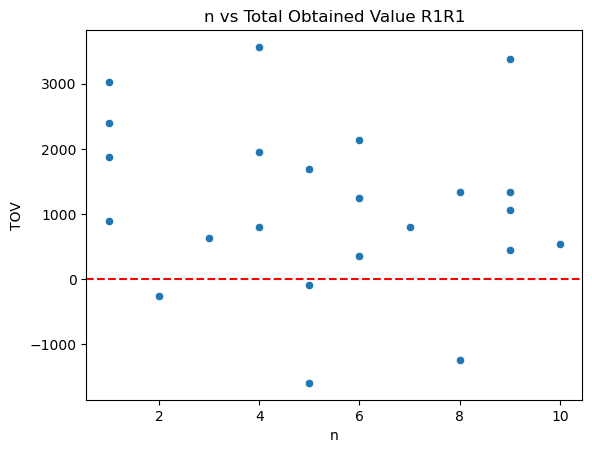

                           TOV Mean       TOV SD
chartist_day_reference                          
1                       2046.718975   906.264937
2                       -266.287800          NaN
3                        622.411700          NaN
4                       2107.499467  1388.632671
5                          2.237433  1646.086468
6                       1245.357275   727.059014
7                        799.289100          NaN
8                         44.689500  1821.546808
9                       1557.444825  1274.160569
10                       533.523000          NaN


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                            1.000000      0.00000
2                            2.000000          NaN
3                            1.000000          NaN
4                            3.666667      0.57735
5                            1.333333      0.57735
6                            1.500000      0.57735
7 

In [273]:
results_chartist_R1R1_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R1_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.CloseSMA == True)]

g_R1R1 = sns.scatterplot(data=results_chartist_R1R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R1_df = avg_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R1_df = sd_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R1'])
avg_open_pos_per_n_R1R1_df = avg_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos Mean'})
sd_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R1'])
sd_open_pos_per_n_R1R1_df = sd_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos SD'})

print(avg_TVO_per_n_R1R1_df.merge(sd_TVO_per_n_R1R1_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R1R1_df.merge(sd_open_pos_per_n_R1R1_df, on='chartist_day_reference',how='left'))


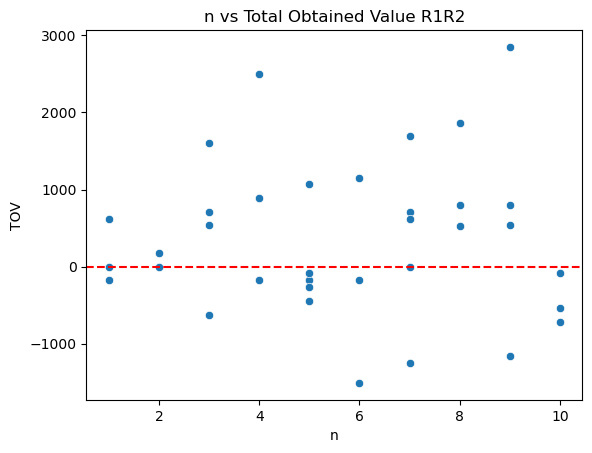

                           TOV Mean       TOV SD
chartist_day_reference                          
1                        148.179567   420.137293
2                         88.209400   124.613145
3                        555.231575   912.502926
4                       1068.184833  1344.649944
5                         18.337280   601.382366
6                       -176.730467  1332.268207
7                        356.736420  1080.554530
8                       1066.098200   706.195273
9                        757.562075  1641.207966
10                      -444.666133   320.860645


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                                 0.0          0.0
2                                 0.0          0.0
3                                 0.0          0.0
4                                 0.0          0.0
5                                 0.0          0.0
6                                 0.0          0.0
7 

In [274]:
results_chartist_R1R2_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R2_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.CloseSMA == False)]

g_R1R2 = sns.scatterplot(data=results_chartist_R1R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R2_df = avg_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R2_df = sd_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R2'])
avg_open_pos_per_n_R1R2_df = avg_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos Mean'})
sd_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R2'])
sd_open_pos_per_n_R1R2_df = sd_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos SD'})

print(avg_TVO_per_n_R1R2_df.merge(sd_TVO_per_n_R1R2_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R1R2_df.merge(sd_open_pos_per_n_R1R2_df, on='chartist_day_reference',how='left'))

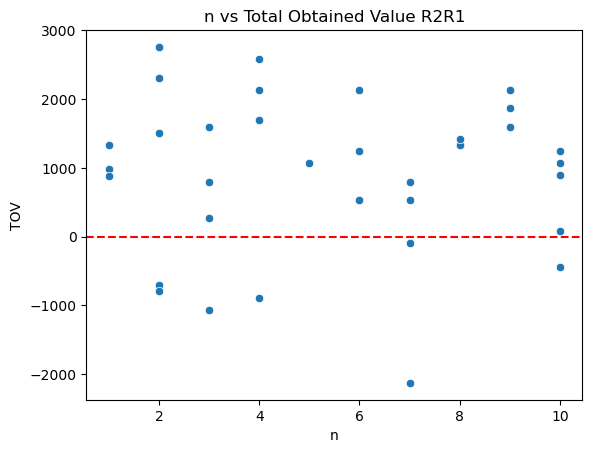

                           TOV Mean       TOV SD
chartist_day_reference                          
1                       1066.655900   235.626242
2                       1613.090438  1518.288217
3                        400.970900  1118.219531
4                       1380.099650  1554.652994
5                       1066.507600          NaN
6                       1111.814550   761.208820
7                       -221.047100  1325.250801
8                       1362.439333    50.607250
9                       1935.110150   256.137511
10                       568.100460   719.835291


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                                 0.0          0.0
2                                 0.0          0.0
3                                 0.0          0.0
4                                 0.0          0.0
5                                 0.0          NaN
6                                 0.0          0.0
7 

In [275]:
results_chartist_R2R1_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R1_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.CloseSMA == True)]

g_R2R1 = sns.scatterplot(data=results_chartist_R2R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R1_df = avg_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R1_df = sd_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R1'])
avg_open_pos_per_n_R2R1_df = avg_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos Mean'})
sd_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R1'])
sd_open_pos_per_n_R2R1_df = sd_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos SD'})

print(avg_TVO_per_n_R2R1_df.merge(sd_TVO_per_n_R2R1_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R2R1_df.merge(sd_open_pos_per_n_R2R1_df, on='chartist_day_reference',how='left'))

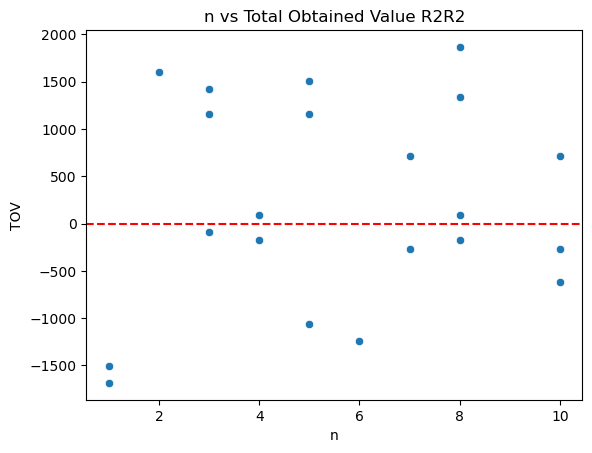

                           TOV Mean       TOV SD
chartist_day_reference                          
1                      -1596.167200   125.640147
2                       1601.327000          NaN
3                        829.982800   806.669442
4                        -44.002150   189.410077
5                        533.621333  1396.120422
6                      -1242.707200          NaN
7                        222.680450   691.639174
8                        777.872350   980.643757
10                       -58.965033   689.927297


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                            1.500000     0.707107
2                            1.000000          NaN
3                            1.666667     0.577350
4                            1.500000     2.121320
5                            1.000000     0.000000
6                            0.000000          NaN
7                            1.000000     0.000000


In [276]:
results_chartist_R2R2_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R2_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.CloseSMA == False)]

g_R2R2 = sns.scatterplot(data=results_chartist_R2R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R2_df = avg_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R2_df = sd_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R2'])
avg_open_pos_per_n_R2R2_df = avg_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos Mean'})
sd_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R2'])
sd_open_pos_per_n_R2R2_df = sd_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos SD'})

print(avg_TVO_per_n_R2R2_df.merge(sd_TVO_per_n_R2R2_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R2R2_df.merge(sd_open_pos_per_n_R2R2_df, on='chartist_day_reference',how='left'))

## Task 2.2 Agent Comparisons

In [281]:
best_n = 8

results_chartist_R1R1__best_n_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.chartist_day_reference == best_n)]
results_chartist_R1R2__best_n_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.chartist_day_reference == best_n)]
results_chartist_R2R1__best_n_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.chartist_day_reference == best_n)]
results_chartist_R2R2__best_n_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.chartist_day_reference == best_n)]

results_random_df = results_df[(results_df["AgentID"].str.contains("random"))]
results_random_df = results_random_df[(results_random_df.Step == max_steps)]
results_random_best_n_df = results_random_df[(results_random_df.chartist_day_reference == best_n)]

# print(results_chartist_R1R1__best_n_df.head(3))

In [295]:
print('TOV')
summary_TOV = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['TOV'],
           results_random_best_n_df.mean(numeric_only=True)['TOV']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['TOV'], 
           results_random_best_n_df.std(numeric_only=True)['TOV']]
})
print(summary_TOV)

fig = px.histogram(summary_TOV, x="Agent Name" , y=["Avg", "SD"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Column1 and Column2',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.show()

TOV
  Agent Name          Avg           SD
0       R1R1    44.689500  1821.546808
1       R1R2  1066.098200   706.195273
2       R2R1  1362.439333    50.607250
3       R2R2   777.872350   980.643757
4     Random   901.734512  1160.754005


In [283]:
print('Open Position')
summary_open_pos = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['Open_R1R1'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['Open_R1R2'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['Open_R2R1'],
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['Open_R2R2'],
           results_random_best_n_df.mean(numeric_only=True)['Open_Random']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['Open_R1R1'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['Open_R1R2'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['Open_R2R1'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['Open_R2R2'], 
           results_random_best_n_df.std(numeric_only=True)['Open_Random']]
}).set_index("Agent Name", inplace = True)
print(summary_open_pos)

Open Position
  Agent Name  Avg        SD
0       R1R1  1.0  0.000000
1       R1R2  0.0  0.000000
2       R2R1  0.0  0.000000
3       R2R2  0.5  1.000000
4     Random  1.5  1.603567


In [284]:
print('Ratio Bitcoin vs Fiat')
summary_ratio = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['RBF'],
           results_random_best_n_df.mean(numeric_only=True)['RBF']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['RBF'], 
           results_random_best_n_df.std(numeric_only=True)['RBF']]
}).set_index("Agent Name", inplace = True)
print(summary_ratio)

Ratio Bitcoin vs Fiat
  Agent Name         Avg           SD
0       R1R1  168.840000   238.775818
1       R1R2   55.956667    96.919790
2       R2R1   84.380000   146.150447
3       R2R2   41.967500    83.935000
4     Random  531.630000  1048.536489


In [ ]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_price_df = results_df.copy()
results_price_df = results_price_df.loc[:,["iteration", "Step", "Price"]]
results_price_df = results_price_df.groupby(['iteration', 'Step']).max()['Price']
results_price_df = results_price_df.groupby(["Step"]).mean()
print(results_price_df.groupby(["Step"]).mean())

fig = px.line(results_price_df, y = 'Price', title = 'Price', markers = True)

fig.show()

In [ ]:
total_bitcoin = 10000
total_fiat = 5000000

# Agents Parameters
number_of_agents = 5 # In 2020, there are 420M users
chartist_day_reference = 3
chartist_ratio = 0.5

price_start = 5614

model = BitcoinMarketModel(price_start, 
                           number_of_agents, 
                           total_fiat, 
                           total_bitcoin, 
                           chartist_ratio, 
                           chartist_day_reference)

for i in range(10):
#     print(f'progress : {i}/1399')
    model.step()
    
data = model.datacollector.get_model_vars_dataframe()

price_df = pd.DataFrame(data=data.Price)
fig = px.line(price_df, y = 'Price', title = 'Price', markers = True)

fig.show()

agent_variables = model.datacollector.get_agent_vars_dataframe()
end_state = agent_variables.index.get_level_values("Step").max()
end_state_total_value = agent_variables.xs(end_state, level="Step")["TV"]
agents_total_value_df = pd.DataFrame(data=end_state_total_value)

# # Create a histogram of wealth at the last step
counts, bins = np.histogram(agents_total_value_df, bins=range(0, 5000000, 1000000))
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'total_values', 'y':'count'})
fig.show()